# Fragility Comparison Analysis

This notebook generates comparison plots across different fragility levels:
- Block 4: Success Rate vs Position Noise (2×2 grid)
- Block 5: Break Rate vs Position Noise (2×2 grid with N/A for unbreakable)
- Gold highlight box around the reference fragility level

In [48]:
# ============================================================
# BLOCK 1: IMPORTS & CONSTANTS
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

# WandB Configuration
ENTITY = "hur"
PROJECT = "SG_Exps"

# Fragility Levels - keys are internal names, each contains method tags
FRAGILITY_LEVELS = {
    #"5N": {
    #    "Pose": "pose_task_frag:2026-01-06_09:18",
    #    "Hybrid-Basic": "basic-hybrid_task_frag:2026-01-06_03:15",
    #    "LCLoP": "LCLoP_task_frag:2026-01-06_02:47",
    #},
    "10N": {
        "Pose(1mm)": "pose_perf-comp:2026-01-05_10:54",
        #"Pose-7.5mm":"pose_75mm-noise:2026-01-16_19:08",
        "Pose(2.5mm)" : "pose_25mm-noise:2026-01-19_07:50",
        #"LCLoP": "LCLoP_perf-comp:2026-01-05_10:54",
        "SWISH(1mm)": "LCLoP_fix_perf-comp:2026-01-09_11:17",
        "Hybrid-Basic(1mm)": "basic-hybrid_perf-comp:2026-01-05_10:54",
    },
    "15N": {
        "Pose(1mm)": "pose_task_frag:2026-01-06_00:52",
        #"Pose-7.5mm":"pose_75mm-noise:2026-01-17_19:18",
        "Pose(2.5mm)" : "pose_25mm-noise:2026-01-19_07:50_15N",
        "SWISH(1mm)": "LCLoP_task_frag:2026-01-06_00:27",
        "Hybrid-Basic(1mm)": "basic-hybrid_task_frag:2026-01-06_00:56",
    },
    "20N": {
        "Pose(1mm)": "pose_task_frag:2026-01-06_00:09",
        #"Pose-7.5mm":"pose_75mm-noise:2026-01-18_12:50",
        "Pose(2.5mm)" : "pose_25mm-noise:2026-01-19_07:50_20N",
        "SWISH(1mm)": "LCLoP_task_frag:2026-01-06_00:09",
        "Hybrid-Basic(1mm)": "basic-hybrid_task_frag:2026-01-06_09:18",
    },
    "10000N": {
        "Pose(1mm)": "pose_task_frag:2026-01-05_23:37",
        "Pose(2.5mm)" : "pose_25mm-noise:2026-01-19_07:50_unbreak",
        #"Pose-7.5mm":"pose_75mm-noise:2026-01-17_19:38",
        "SWISH(1mm)": "LCLoP_task_frag:2026-01-05_22:12",
        "Hybrid-Basic(1mm)": "basic-hybrid_task_frag:2026-01-06_00:08",
    },
}

# Display name mapping (for special cases like 10000N -> Unbreakable)
FRAGILITY_DISPLAY_NAMES = {
    "5N": "$F_{th}$ = 5N",
    "10N": "$F_{th}$ = 10N",
    "15N": "$F_{th}$ = 15N",
    "20N": "$F_{th}$ = 20N",
    "10000N": "Unbreakable",
}

# Highlight box - which fragility level to highlight with gold box
HIGHLIGHT_FRAGILITY = "15N"  # Set to None for no highlight

# Evaluation Tags
TAG_EVAL_PERFORMANCE = "eval_performance"
TAG_EVAL_NOISE = "eval_noise"

# Old Noise Eval Filter
# Set to: None (no filter), "include" (only old_noise_eval), or "exclude" (exclude old_noise_eval)
OLD_NOISE_EVAL_FILTER = "exclude"
TAG_OLD_NOISE_EVAL = "old_noise_eval"

# Noise Level Mapping: display label -> metric range string
NOISE_LEVELS = {
    "1mm": "0mm-1mm",
    "2.5mm": "1mm-2.5mm",
    "5mm": "2.5mm-5mm",
    "7.5mm": "5mm-7.5mm",
}

# Metrics
METRIC_SUCCESS = "num_successful_completions"
METRIC_BREAKS = "num_breaks"
METRIC_TOTAL = "total_episodes"

In [49]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

def get_best_checkpoint_per_run(api, method_tag):
    """Find the best checkpoint for each run with the given method tag."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    best_checkpoints = {}
    for run in runs:
        history = run.history()
        if history.empty:
            print(f"Warning: Run {run.name} has no history data")
            continue
        
        # Calculate score: successes - breaks
        history["score"] = history[f"Eval_Core/{METRIC_SUCCESS}"] - history[f"Eval_Core/{METRIC_BREAKS}"]
        best_idx = history["score"].idxmax()
        best_step = int(history.loc[best_idx, "total_steps"])
        
        best_checkpoints[run.id] = {
            "run_name": run.name,
            "best_step": best_step,
            "score": history.loc[best_idx, "score"],
        }
        print(f"    {run.name}: best checkpoint at step {best_step} (score: {history.loc[best_idx, 'score']:.0f})")
    
    return best_checkpoints

# Get best checkpoints for each fragility level and method
api = wandb.Api()
best_checkpoints = defaultdict(dict)  # best_checkpoints[fragility][method]

for fragility, method_tags in FRAGILITY_LEVELS.items():
    print(f"\n{'='*60}")
    print(f"Fragility: {fragility}")
    print(f"{'='*60}")
    for method_name, method_tag in method_tags.items():
        print(f"\n  {method_name} ({method_tag}):")
        best_checkpoints[fragility][method_name] = get_best_checkpoint_per_run(api, method_tag)


Fragility: 10N

  Pose(1mm) (pose_perf-comp:2026-01-05_10:54):
    Eval_performance_pose_perf-comp_f(10)_0: best checkpoint at step 1228800 (score: 95)
    Eval_performance_pose_perf-comp_f(10)_1: best checkpoint at step 1536000 (score: 97)
    Eval_performance_pose_perf-comp_f(10)_3: best checkpoint at step 1920000 (score: 91)
    Eval_performance_pose_perf-comp_f(10)_4: best checkpoint at step 1113600 (score: 97)
    Eval_performance_pose_perf-comp_f(10)_2: best checkpoint at step 2496000 (score: 96)

  Pose(2.5mm) (pose_25mm-noise:2026-01-19_07:50):
    Eval_performance_pose_25mm-noise_f(10)_0: best checkpoint at step 3878400 (score: 91)
    Eval_performance_pose_25mm-noise_f(10)_1: best checkpoint at step 2380800 (score: 84)
    Eval_performance_pose_25mm-noise_f(10)_4: best checkpoint at step 3148800 (score: 73)
    Eval_performance_pose_25mm-noise_f(10)_2: best checkpoint at step 3916800 (score: 79)
    Eval_performance_pose_25mm-noise_f(10)_3: best checkpoint at step 3955200 (s

In [50]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

def download_eval_noise_data(api, method_tag, best_checkpoints, old_noise_filter=None):
    """Download eval_noise data for best checkpoints across all noise levels.
    
    Args:
        old_noise_filter: None (no filter), "include" (only old_noise_eval), or "exclude" (exclude old_noise_eval)
    """
    # Build base filter
    base_filters = [{"tags": method_tag}, {"tags": TAG_EVAL_NOISE}]
    
    # Add old_noise_eval filter if specified
    if old_noise_filter == "include":
        base_filters.append({"tags": TAG_OLD_NOISE_EVAL})
    elif old_noise_filter == "exclude":
        base_filters.append({"tags": {"$ne": TAG_OLD_NOISE_EVAL}})
    
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": base_filters}
    )

    # Build lookup by agent number from best_checkpoints
    checkpoint_by_agent = {}
    for run_id, info in best_checkpoints.items():
        agent_num = info["run_name"].rsplit("_", 1)[-1]
        checkpoint_by_agent[agent_num] = info["best_step"]

    data = []
    for run in runs:
        # Extract agent number from run name
        agent_num = run.name.rsplit("_", 1)[-1]

        if agent_num not in checkpoint_by_agent:
            print(f"Warning: No matching performance run for agent {agent_num} ({run.name})")
            continue

        best_step = checkpoint_by_agent[agent_num]
        history = run.history()
        
        if best_step not in history["total_steps"].values:
            print(f"Warning: Checkpoint {best_step} not found in {run.name}")
            continue
        
        row = history[history["total_steps"] == best_step].iloc[0]
        
        for noise_label, noise_range in NOISE_LEVELS.items():
            prefix = f"Noise_Eval({noise_range})_Core"
            data.append({
                "run_id": run.id,
                "run_name": run.name,
                "checkpoint": best_step,
                "noise_level": noise_label,
                "success": row[f"{prefix}/{METRIC_SUCCESS}"],
                "breaks": row[f"{prefix}/{METRIC_BREAKS}"],
                "total": row[f"{prefix}/{METRIC_TOTAL}"],
            })
    
    return pd.DataFrame(data)

# Download all data
noise_data = defaultdict(dict)  # noise_data[fragility][method]

print(f"Old Noise Eval Filter: {OLD_NOISE_EVAL_FILTER}")

for fragility, method_tags in FRAGILITY_LEVELS.items():
    print(f"\n{'='*60}")
    print(f"Downloading data for Fragility: {fragility}")
    print(f"{'='*60}")
    for method_name, method_tag in method_tags.items():
        print(f"\n  {method_name}...")
        noise_data[fragility][method_name] = download_eval_noise_data(
            api, method_tag, best_checkpoints[fragility][method_name],
            old_noise_filter=OLD_NOISE_EVAL_FILTER
        )

# Print summary
print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
for fragility in FRAGILITY_LEVELS.keys():
    print(f"\n{fragility}:")
    for method_name in FRAGILITY_LEVELS[fragility].keys():
        df = noise_data[fragility][method_name]
        if not df.empty:
            num_runs = df["run_name"].nunique()
            print(f"  {method_name}: {num_runs} runs")
        else:
            print(f"  {method_name}: No data")

Old Noise Eval Filter: exclude


  Pose(1mm)...

  Pose(2.5mm)...

  SWISH(1mm)...

  Hybrid-Basic(1mm)...


  Pose(1mm)...

  Pose(2.5mm)...

  SWISH(1mm)...

  Hybrid-Basic(1mm)...


  Pose(1mm)...

  Pose(2.5mm)...

  SWISH(1mm)...

  Hybrid-Basic(1mm)...


  Pose(1mm)...

  Pose(2.5mm)...

  SWISH(1mm)...

  Hybrid-Basic(1mm)...

DATA SUMMARY

10N:
  Pose(1mm): 5 runs
  Pose(2.5mm): 5 runs
  SWISH(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs

15N:
  Pose(1mm): 5 runs
  Pose(2.5mm): 5 runs
  SWISH(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs

20N:
  Pose(1mm): 5 runs
  Pose(2.5mm): 5 runs
  SWISH(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs

10000N:
  Pose(1mm): 5 runs
  Pose(2.5mm): 5 runs
  SWISH(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs


SUCCESS RATE (%) - Mean ± Std Err

$F_{th}$ = 10N:
------------------------------------------------------------
  Pose(1mm)       1mm: 95.2 ± 0.7  |  2.5mm: 76.8 ± 2.2  |  5mm: 18.4 ± 1.7  |  7.5mm: 0.2 ± 0.2
  Pose(2.5mm)     1mm: 98.8 ± 0.2  |  2.5mm: 94.8 ± 1.5  |  5mm: 40.8 ± 3.1  |  7.5mm: 1.2 ± 0.4
  SWISH(1mm)      1mm: 91.6 ± 2.5  |  2.5mm: 82.0 ± 3.7  |  5mm: 35.2 ± 2.2  |  7.5mm: 1.6 ± 0.7
  Hybrid-Basic(1mm) 1mm: 96.0 ± 1.5  |  2.5mm: 83.0 ± 2.1  |  5mm: 28.2 ± 2.5  |  7.5mm: 0.8 ± 0.6

$F_{th}$ = 15N:
------------------------------------------------------------
  Pose(1mm)       1mm: 98.6 ± 0.2  |  2.5mm: 95.2 ± 0.5  |  5mm: 55.8 ± 2.6  |  7.5mm: 7.2 ± 0.9
  Pose(2.5mm)     1mm: 99.4 ± 0.4  |  2.5mm: 97.0 ± 0.9  |  5mm: 57.2 ± 5.9  |  7.5mm: 2.4 ± 0.9
  SWISH(1mm)      1mm: 94.6 ± 1.1  |  2.5mm: 94.8 ± 0.9  |  5mm: 74.2 ± 3.0  |  7.5mm: 29.2 ± 2.1
  Hybrid-Basic(1mm) 1mm: 98.2 ± 0.8  |  2.5mm: 92.2 ± 0.8  |  5mm: 61.8 ± 4.4  |  7.5mm: 10.4 ± 1.7

$F_{th}$ = 20N:
-----------

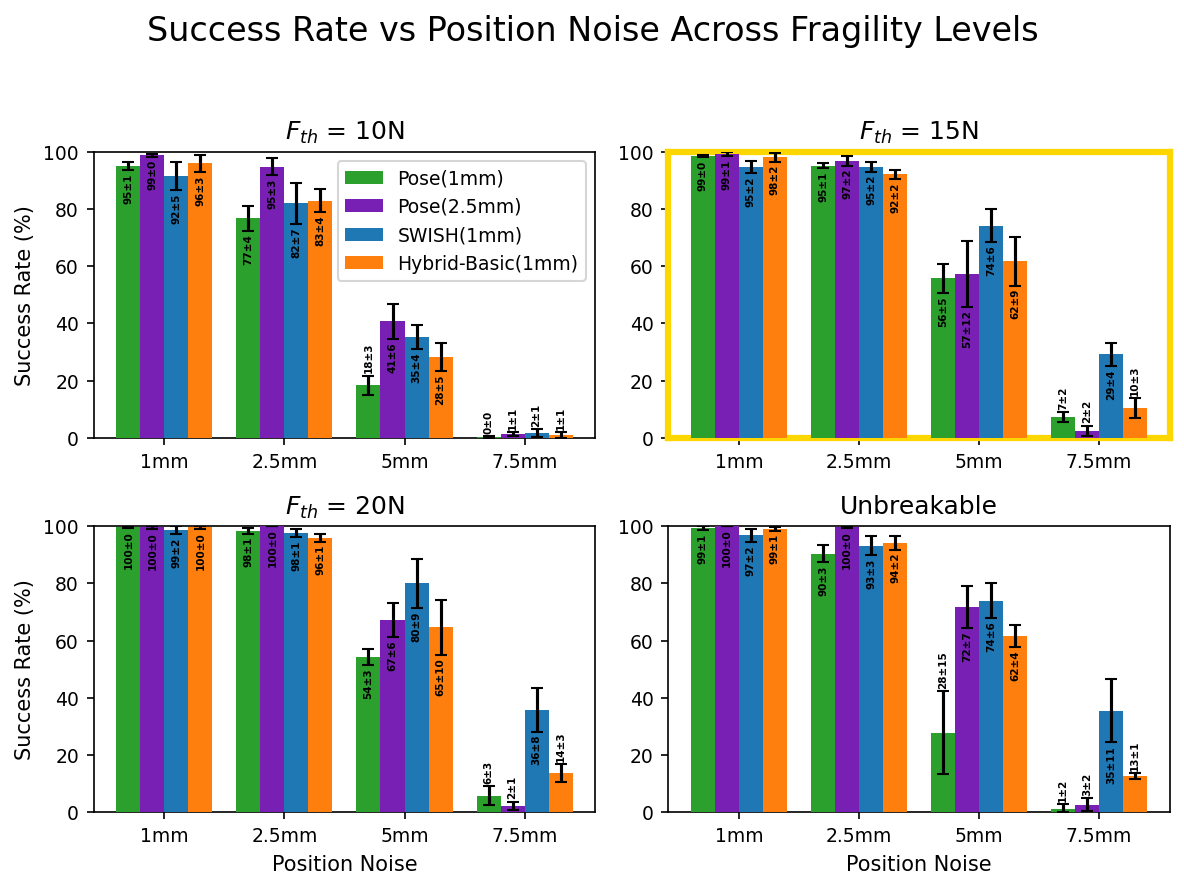

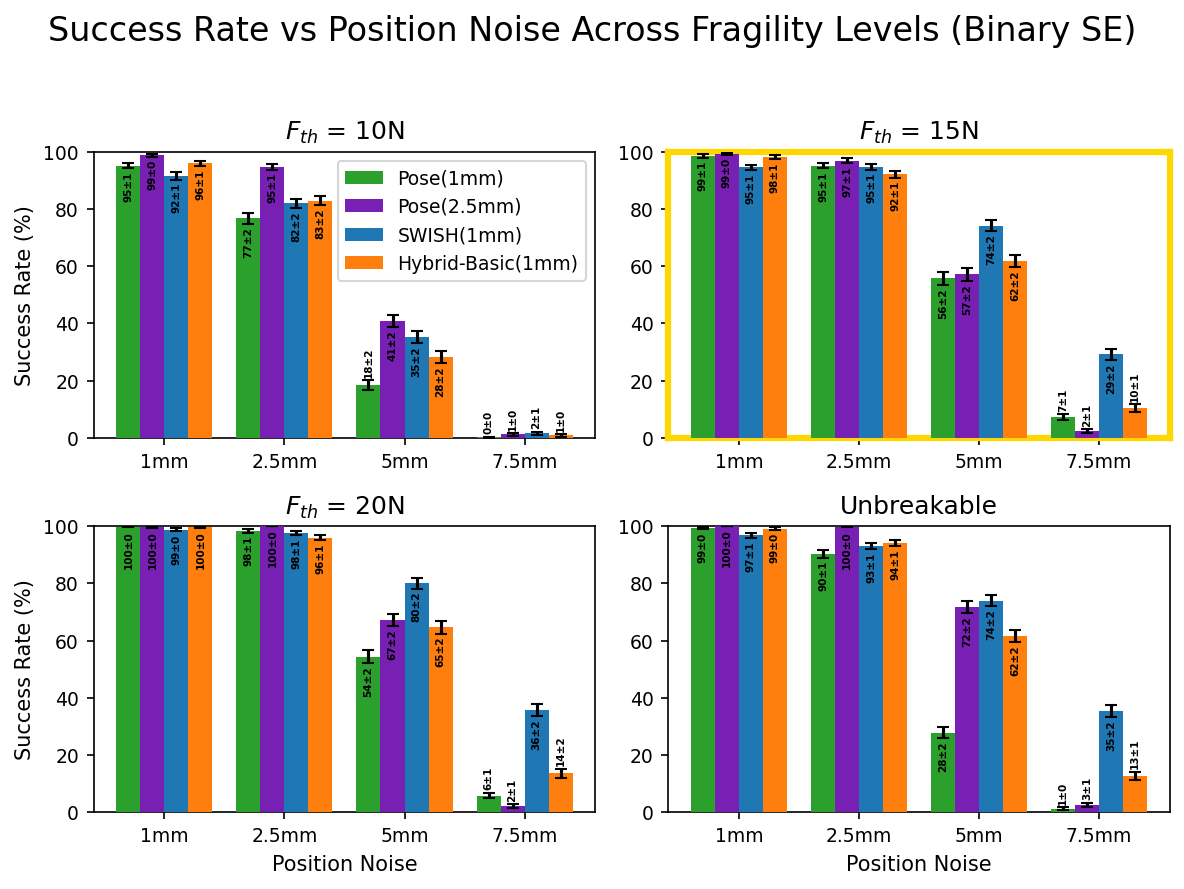

In [53]:
# ============================================================
# BLOCK 4: SUCCESS RATE COMPARISON FIGURE
# ============================================================

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all

# Highlight Configuration
HIGHLIGHT_FRAGILITY_PLOT = "15N"  # Which fragility to highlight with gold box, or None
HIGHLIGHT_COLOR = "gold"
HIGHLIGHT_LINEWIDTH = 3

# Figure Configuration
FIGSIZE = (8, 6)  # Width x Height for 2x2 grid
DPI = 150

# Bar width is calculated dynamically based on number of methods
# GROUP_WIDTH is the total width allocated to bars in each group (0.8 leaves some spacing)
GROUP_WIDTH = 0.8

# Colors
""" THE COLORS KEY SHOULD NOT BE CHANGED FOR ANY REASON WITHOUT USER PERMISSION DO NOT OVERWRITE!!!"""
COLORS = {
    "Pose(1mm)": "#2ca02c",        # Green
    "Hybrid-Basic(1mm)": "#ff7f0e", # Orange
    "SWISH(1mm)": "#1f77b4",       # Blue
    "Pose(2.5mm)": "#781fb4",       # Purple
    "SWISH(2.5mm)": "#b41f1f",
    "Hybrid-Basic(2.5mm)":"#b4aa1f",
}

# Font sizes
FONT_SUPTITLE = 16
FONT_TITLE = 12
FONT_AXIS_LABEL = 10
FONT_TICK = 9
FONT_LEGEND = 9
FONT_BAR_LABEL = 5  # Font size for bar value labels (smaller for grid)

# Axis configuration
SUCCESS_Y_LIM = (0, 100)
SUCCESS_Y_TICKS = [0, 20, 40, 60, 80, 100]

# Labels
SUPTITLE = "Success Rate vs Position Noise Across Fragility Levels"
SUPTITLE_BINARY_SE = "Success Rate vs Position Noise Across Fragility Levels (Binary SE)"
X_LABEL = "Position Noise"
SUCCESS_Y_LABEL = "Success Rate (%)"

# ============================================================

def filter_top_n_runs(df, method_best_checkpoints, top_n):
    """Filter dataframe to only include top N runs by score."""
    if df.empty or top_n is None or len(method_best_checkpoints) <= top_n:
        return df
    sorted_runs = sorted(method_best_checkpoints.items(), key=lambda x: x[1]["score"], reverse=True)
    top_run_names = {info["run_name"] for _, info in sorted_runs[:top_n]}
    # Match by agent number
    top_agent_nums = {name.rsplit("_", 1)[-1] for name in top_run_names}
    return df[df["run_name"].apply(lambda x: x.rsplit("_", 1)[-1] in top_agent_nums)]

def compute_rates_with_ci(df, noise_labels, metric="success"):
    """Compute rates with 95% CI for each noise level. Returns means, cis, lower errors, upper errors."""
    if df.empty:
        zeros = [0] * len(noise_labels)
        return zeros, zeros, zeros, zeros
    
    means = []
    cis = []
    errors_lower = []
    errors_upper = []
    
    for noise_label in noise_labels:
        subset = df[df["noise_level"] == noise_label]
        if not subset.empty:
            # Calculate per-seed rates
            subset = subset.copy()
            subset["rate"] = 100 * subset[metric] / subset["total"]
            mean = subset["rate"].mean()
            std = subset["rate"].std()
            n_seeds = len(subset)
            sem = std / np.sqrt(n_seeds)
            ci = 1.96 * sem
            # Clip error bars to [0, 100] range
            errors_lower.append(min(ci, mean - 0))
            errors_upper.append(min(ci, 100 - mean))
            means.append(mean)
            cis.append(ci)
        else:
            means.append(0)
            cis.append(0)
            errors_lower.append(0)
            errors_upper.append(0)
    
    return means, cis, errors_lower, errors_upper

def compute_rates_with_binary_se(df, noise_labels, metric="success"):
    """Compute rates with binary SE for each noise level. Returns means, ses, lower errors, upper errors."""
    if df.empty:
        zeros = [0] * len(noise_labels)
        return zeros, zeros, zeros, zeros
    
    means = []
    binary_ses = []
    
    for noise_label in noise_labels:
        subset = df[df["noise_level"] == noise_label]
        if not subset.empty:
            total_successes = subset[metric].sum()
            total_episodes = subset["total"].sum()
            p = total_successes / total_episodes  # proportion (0-1)
            mean_pct = p * 100
            # Binary SE: sqrt(p*(1-p)/n) converted to percentage
            se = np.sqrt(p * (1 - p) / total_episodes) * 100
            means.append(mean_pct)
            binary_ses.append(se)
        else:
            means.append(0)
            binary_ses.append(0)
    
    # Clip error bars to [0, 100] range
    errors_lower = [min(se, mean) for mean, se in zip(means, binary_ses)]
    errors_upper = [min(se, 100 - mean) for mean, se in zip(means, binary_ses)]
    
    return means, binary_ses, errors_lower, errors_upper

def compute_rates_with_sem(df, noise_labels, metric="success"):
    """Compute rates with SEM for each noise level. Returns means and SEMs."""
    if df.empty:
        zeros = [0] * len(noise_labels)
        return zeros, zeros
    
    means = []
    sems = []
    
    for noise_label in noise_labels:
        subset = df[df["noise_level"] == noise_label]
        if not subset.empty:
            subset = subset.copy()
            subset["rate"] = 100 * subset[metric] / subset["total"]
            mean = subset["rate"].mean()
            std = subset["rate"].std()
            n_seeds = len(subset)
            sem = std / np.sqrt(n_seeds)
            means.append(mean)
            sems.append(sem)
        else:
            means.append(0)
            sems.append(0)
    
    return means, sems

# Setup
fragility_keys = list(FRAGILITY_LEVELS.keys())
method_names = list(FRAGILITY_LEVELS[fragility_keys[0]].keys())
noise_labels = list(NOISE_LEVELS.keys())
n_fragilities = len(fragility_keys)
x = np.arange(len(noise_labels))

# Calculate bar width dynamically based on number of methods
n_methods = len(method_names)
BAR_WIDTH = GROUP_WIDTH / n_methods

# Print success rate values
print("=" * 80)
print("SUCCESS RATE (%) - Mean ± Std Err")
print("=" * 80)
for fragility in fragility_keys:
    display_name = FRAGILITY_DISPLAY_NAMES.get(fragility, fragility)
    print(f"\n{display_name}:")
    print("-" * 60)
    for method_name in method_names:
        if method_name not in noise_data[fragility].keys():
            continue
        df = noise_data[fragility][method_name]
        df = filter_top_n_runs(df, best_checkpoints[fragility][method_name], TOP_N_POLICIES)
        means, sems = compute_rates_with_sem(df, noise_labels, "success")
        values_str = "  |  ".join([f"{noise_labels[i]}: {means[i]:.1f} ± {sems[i]:.1f}" for i in range(len(noise_labels))])
        print(f"  {method_name:15s} {values_str}")

# Calculate grid dimensions (2 rows, ceil(n/2) columns)
n_cols = (n_fragilities + 1) // 2
n_rows = 2

# ============================================================
# PLOT 1: Success Rate with 95% CI (per-seed variation)
# ============================================================
fig, axes = plt.subplots(n_rows, n_cols, figsize=FIGSIZE, dpi=DPI)
fig.suptitle(SUPTITLE, fontsize=FONT_SUPTITLE)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Plot each fragility level
for idx, fragility in enumerate(fragility_keys):
    ax = axes_flat[idx]
    
    display_name = FRAGILITY_DISPLAY_NAMES.get(fragility, fragility)
    
    # Plot bars for each method (success rate)
    for i, method_name in enumerate(method_names):
        if method_name not in noise_data[fragility].keys():
            continue
        df = noise_data[fragility][method_name]
        df = filter_top_n_runs(df, best_checkpoints[fragility][method_name], TOP_N_POLICIES)
        
        success_means, success_cis, success_err_lo, success_err_hi = compute_rates_with_ci(df, noise_labels, "success")
        offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
        
        bars = ax.bar(x + offset, success_means, BAR_WIDTH, 
               label=method_name, color=COLORS[method_name],
               yerr=[success_err_lo, success_err_hi], capsize=3, zorder=3)
        
        # Add rotated mean±CI labels - inside bar if fits, above otherwise
        y_range = SUCCESS_Y_LIM[1] - SUCCESS_Y_LIM[0]
        label_height_estimate = y_range * 0.20  # ~20% of y-range for rotated text

        for bar, mean, ci, err_lower, err_upper in zip(bars, success_means, success_cis, success_err_lo, success_err_hi):
            if mean > 0:  # Only label non-zero bars
                # Check if label fits inside the bar
                space_inside = bar.get_height() - err_lower
                if space_inside > label_height_estimate + 2:  # fits inside
                    label_y = bar.get_height() - err_lower - 1
                    va = 'top'
                else:  # place above
                    label_y = bar.get_height() + err_upper + 1
                    va = 'bottom'

                ax.text(bar.get_x() + bar.get_width()/2, label_y,
                       f'{mean:.0f}±{ci:.0f}', ha='center', va=va,
                       rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')

    # Configure subplot
    ax.set_title(display_name, fontsize=FONT_TITLE)
    ax.set_xticks(x)
    ax.set_xticklabels(noise_labels, fontsize=FONT_TICK)
    ax.set_ylim(SUCCESS_Y_LIM)
    ax.set_yticks(SUCCESS_Y_TICKS)
    ax.tick_params(axis='y', labelsize=FONT_TICK)
    
    # Only show x-axis label on bottom row
    row = idx // n_cols
    if row == n_rows - 1:
        ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
    
    # Only show y-axis label on leftmost column
    col = idx % n_cols
    if col == 0:
        ax.set_ylabel(SUCCESS_Y_LABEL, fontsize=FONT_AXIS_LABEL)
    
    # Only show legend on first plot
    if idx == 0:
        ax.legend(fontsize=FONT_LEGEND, loc='upper right')
    
    # Add gold highlight to spines if this is the highlighted fragility
    if HIGHLIGHT_FRAGILITY_PLOT is not None and fragility == HIGHLIGHT_FRAGILITY_PLOT:
        for spine in ['top', 'left', 'right', 'bottom']:
            ax.spines[spine].set_color(HIGHLIGHT_COLOR)
            ax.spines[spine].set_linewidth(HIGHLIGHT_LINEWIDTH)

# Hide any unused subplots (if n_fragilities is odd)
for idx in range(n_fragilities, len(axes_flat)):
    axes_flat[idx].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for suptitle
plt.show()

# ============================================================
# PLOT 2: Success Rate with Binary SE
# ============================================================
fig, axes = plt.subplots(n_rows, n_cols, figsize=FIGSIZE, dpi=DPI)
fig.suptitle(SUPTITLE_BINARY_SE, fontsize=FONT_SUPTITLE)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Plot each fragility level
for idx, fragility in enumerate(fragility_keys):
    ax = axes_flat[idx]
    
    display_name = FRAGILITY_DISPLAY_NAMES.get(fragility, fragility)
    
    # Plot bars for each method (success rate with binary SE)
    for i, method_name in enumerate(method_names):
        if method_name not in noise_data[fragility].keys():
            continue
        df = noise_data[fragility][method_name]
        df = filter_top_n_runs(df, best_checkpoints[fragility][method_name], TOP_N_POLICIES)
        
        success_means, success_ses, success_err_lo, success_err_hi = compute_rates_with_binary_se(df, noise_labels, "success")
        offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
        
        bars = ax.bar(x + offset, success_means, BAR_WIDTH, 
               label=method_name, color=COLORS[method_name],
               yerr=[success_err_lo, success_err_hi], capsize=3, zorder=3)
        
        # Add rotated mean±SE labels - inside bar if fits, above otherwise
        y_range = SUCCESS_Y_LIM[1] - SUCCESS_Y_LIM[0]
        label_height_estimate = y_range * 0.20

        for bar, mean, se, err_lower, err_upper in zip(bars, success_means, success_ses, success_err_lo, success_err_hi):
            if mean > 0:
                space_inside = bar.get_height() - err_lower
                if space_inside > label_height_estimate + 2:
                    label_y = bar.get_height() - err_lower - 1
                    va = 'top'
                else:
                    label_y = bar.get_height() + err_upper + 1
                    va = 'bottom'

                ax.text(bar.get_x() + bar.get_width()/2, label_y,
                       f'{mean:.0f}±{se:.0f}', ha='center', va=va,
                       rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')

    # Configure subplot
    ax.set_title(display_name, fontsize=FONT_TITLE)
    ax.set_xticks(x)
    ax.set_xticklabels(noise_labels, fontsize=FONT_TICK)
    ax.set_ylim(SUCCESS_Y_LIM)
    ax.set_yticks(SUCCESS_Y_TICKS)
    ax.tick_params(axis='y', labelsize=FONT_TICK)
    
    # Only show x-axis label on bottom row
    row = idx // n_cols
    if row == n_rows - 1:
        ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
    
    # Only show y-axis label on leftmost column
    col = idx % n_cols
    if col == 0:
        ax.set_ylabel(SUCCESS_Y_LABEL, fontsize=FONT_AXIS_LABEL)
    
    # Only show legend on first plot
    if idx == 0:
        ax.legend(fontsize=FONT_LEGEND, loc='upper right')
    
    # Add gold highlight to spines if this is the highlighted fragility
    if HIGHLIGHT_FRAGILITY_PLOT is not None and fragility == HIGHLIGHT_FRAGILITY_PLOT:
        for spine in ['top', 'left', 'right', 'bottom']:
            ax.spines[spine].set_color(HIGHLIGHT_COLOR)
            ax.spines[spine].set_linewidth(HIGHLIGHT_LINEWIDTH)

# Hide any unused subplots (if n_fragilities is odd)
for idx in range(n_fragilities, len(axes_flat)):
    axes_flat[idx].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for suptitle
plt.show()

BREAK RATE (%) - Mean ± Std Err

$F_{th}$ = 10N:
------------------------------------------------------------
  Pose(1mm)       1mm: 3.2 ± 0.7  |  2.5mm: 3.4 ± 1.5  |  5mm: 2.8 ± 0.8  |  7.5mm: 3.2 ± 1.2
  Pose(2.5mm)     1mm: 1.0 ± 0.0  |  2.5mm: 2.8 ± 1.0  |  5mm: 2.6 ± 1.2  |  7.5mm: 3.0 ± 0.8
  SWISH(1mm)      1mm: 6.4 ± 2.8  |  2.5mm: 5.0 ± 1.9  |  5mm: 3.0 ± 1.5  |  7.5mm: 1.2 ± 0.6
  Hybrid-Basic(1mm) 1mm: 1.2 ± 0.2  |  2.5mm: 0.8 ± 0.4  |  5mm: 0.8 ± 0.2  |  7.5mm: 1.0 ± 0.4

$F_{th}$ = 15N:
------------------------------------------------------------
  Pose(1mm)       1mm: 0.8 ± 0.2  |  2.5mm: 0.8 ± 0.4  |  5mm: 0.2 ± 0.2  |  7.5mm: 0.0 ± 0.0
  Pose(2.5mm)     1mm: 0.6 ± 0.4  |  2.5mm: 2.0 ± 0.7  |  5mm: 1.4 ± 0.5  |  7.5mm: 0.0 ± 0.0
  SWISH(1mm)      1mm: 5.0 ± 0.9  |  2.5mm: 2.8 ± 0.7  |  5mm: 3.0 ± 0.6  |  7.5mm: 1.4 ± 0.7
  Hybrid-Basic(1mm) 1mm: 0.4 ± 0.2  |  2.5mm: 1.6 ± 0.6  |  5mm: 0.8 ± 0.6  |  7.5mm: 1.0 ± 0.5

$F_{th}$ = 20N:
---------------------------------------

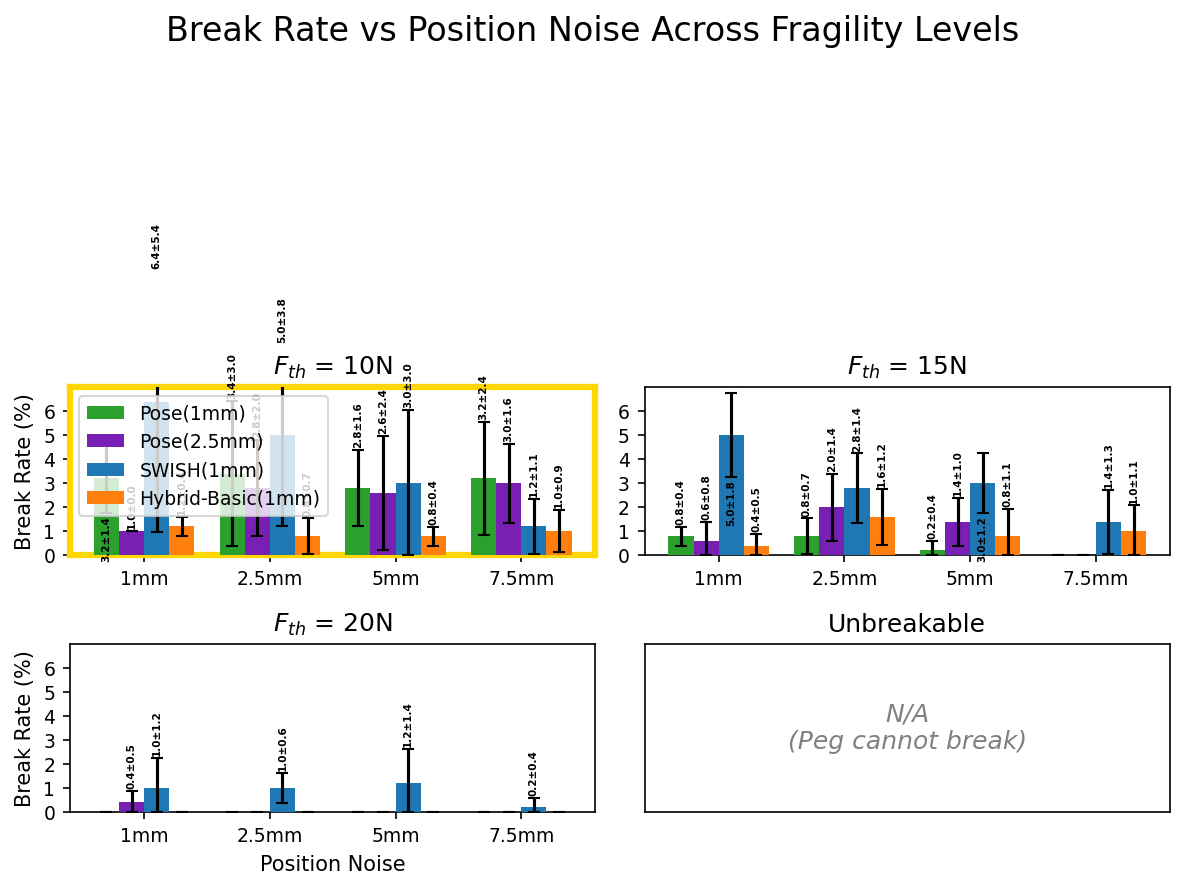

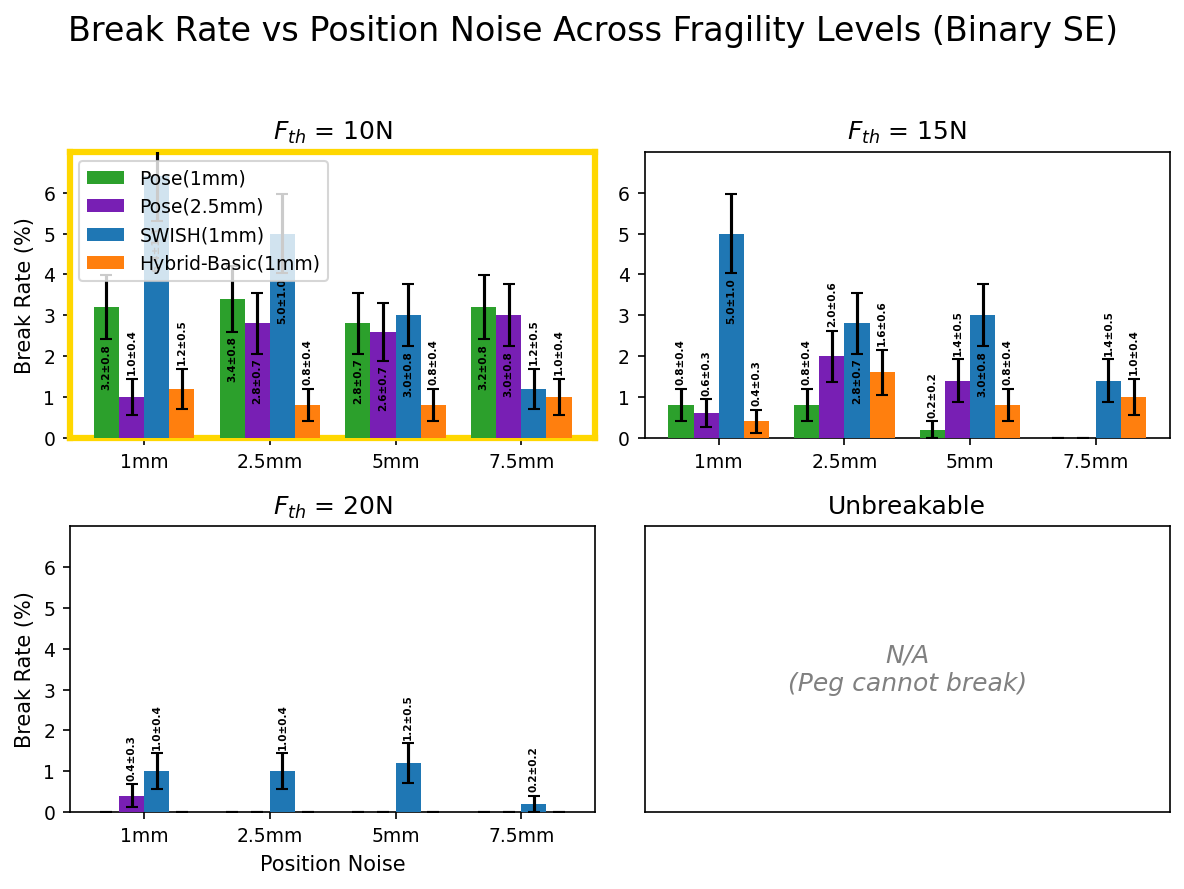

In [52]:
# ============================================================
# BLOCK 5: BREAK RATE COMPARISON FIGURE
# ============================================================

# Policy Selection (uses TOP_N_POLICIES from Block 4)

# Highlight Configuration (uses settings from Block 4)

# N/A Configuration - for fragility levels where break rate is not applicable
NA_FRAGILITIES = ["10000N"]  # List of fragility keys to show N/A instead of break rate plot
NA_TEXT = "N/A\n(Peg cannot break)"  # Text to display in the N/A box

# Figure Configuration
FIGSIZE_BREAK = (8, 6)  # Width x Height for 2x2 grid
DPI_BREAK = 150

# Bar width is calculated dynamically based on number of methods
# GROUP_WIDTH is the total width allocated to bars in each group (0.8 leaves some spacing)
# (uses GROUP_WIDTH from Block 4)

# Axis configuration
BREAK_Y_LIM = (0, 7)
BREAK_Y_TICKS = [i for i in range(BREAK_Y_LIM[1])]

# Labels
SUPTITLE_BREAK = "Break Rate vs Position Noise Across Fragility Levels"
SUPTITLE_BREAK_BINARY_SE = "Break Rate vs Position Noise Across Fragility Levels (Binary SE)"
BREAK_Y_LABEL = "Break Rate (%)"

# Font sizes
FONT_NA = 12  # Font size for N/A text

# ============================================================

# Setup (reuse variables from Block 4)
fragility_keys = list(FRAGILITY_LEVELS.keys())
method_names = list(FRAGILITY_LEVELS[fragility_keys[0]].keys())
noise_labels = list(NOISE_LEVELS.keys())
n_fragilities = len(fragility_keys)
x = np.arange(len(noise_labels))

# Calculate bar width dynamically based on number of methods
n_methods = len(method_names)
BAR_WIDTH = GROUP_WIDTH / n_methods

# Print break rate values
print("=" * 80)
print("BREAK RATE (%) - Mean ± Std Err")
print("=" * 80)
for fragility in fragility_keys:
    display_name = FRAGILITY_DISPLAY_NAMES.get(fragility, fragility)
    is_na_fragility = fragility in NA_FRAGILITIES
    print(f"\n{display_name}:")
    print("-" * 60)
    if is_na_fragility:
        print("  N/A (Peg cannot break)")
    else:
        for method_name in method_names:
            if method_name not in noise_data[fragility].keys():
                continue
            df = noise_data[fragility][method_name]
            df = filter_top_n_runs(df, best_checkpoints[fragility][method_name], TOP_N_POLICIES)
            means, sems = compute_rates_with_sem(df, noise_labels, "breaks")
            values_str = "  |  ".join([f"{noise_labels[i]}: {means[i]:.1f} ± {sems[i]:.1f}" for i in range(len(noise_labels))])
            print(f"  {method_name:15s} {values_str}")

# Calculate grid dimensions (2 rows, ceil(n/2) columns)
n_cols = (n_fragilities + 1) // 2
n_rows = 2

# ============================================================
# PLOT 1: Break Rate with 95% CI (per-seed variation)
# ============================================================
fig, axes = plt.subplots(n_rows, n_cols, figsize=FIGSIZE_BREAK, dpi=DPI_BREAK)
fig.suptitle(SUPTITLE_BREAK, fontsize=FONT_SUPTITLE)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Plot each fragility level
for idx, fragility in enumerate(fragility_keys):
    ax = axes_flat[idx]
    
    display_name = FRAGILITY_DISPLAY_NAMES.get(fragility, fragility)
    is_na_fragility = fragility in NA_FRAGILITIES
    
    if is_na_fragility:
        # Clear the axes and show N/A text
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0.5, 0.5, NA_TEXT, transform=ax.transAxes,
                fontsize=FONT_NA, ha='center', va='center',
                style='italic', color='gray')
        ax.set_title(display_name, fontsize=FONT_TITLE)
        # Keep the spines for visual consistency
        for spine in ax.spines.values():
            spine.set_visible(True)
    else:
        # Plot bars for each method (break rate)
        for i, method_name in enumerate(method_names):
            if method_name not in noise_data[fragility].keys():
                continue
            df = noise_data[fragility][method_name]
            df = filter_top_n_runs(df, best_checkpoints[fragility][method_name], TOP_N_POLICIES)
            
            break_means, break_cis, break_err_lo, break_err_hi = compute_rates_with_ci(df, noise_labels, "breaks")
            offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
            
            bars = ax.bar(x + offset, break_means, BAR_WIDTH,
                   label=method_name, color=COLORS[method_name],
                   yerr=[break_err_lo, break_err_hi], capsize=3, zorder=3)
            
            # Add rotated mean±CI labels - inside bar if fits, above otherwise
            y_range = BREAK_Y_LIM[1] - BREAK_Y_LIM[0]
            label_height_estimate = y_range * 0.20  # ~20% of y-range for rotated text

            for bar, mean, ci, err_lower, err_upper in zip(bars, break_means, break_cis, break_err_lo, break_err_hi):
                if mean > 0:  # Only label non-zero bars
                    # Check if label fits inside the bar
                    space_inside = bar.get_height() - err_lower
                    if space_inside > label_height_estimate + 0.1:  # fits inside
                        label_y = bar.get_height() - err_lower - 0.1
                        va = 'top'
                    else:  # place above
                        label_y = bar.get_height() + err_upper + 0.1
                        va = 'bottom'

                    ax.text(bar.get_x() + bar.get_width()/2, label_y,
                           f'{mean:.1f}±{ci:.1f}', ha='center', va=va,
                           rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')
        
        # Configure subplot
        ax.set_title(display_name, fontsize=FONT_TITLE)
        ax.set_xticks(x)
        ax.set_xticklabels(noise_labels, fontsize=FONT_TICK)
        ax.set_ylim(BREAK_Y_LIM)
        ax.set_yticks(BREAK_Y_TICKS)
        ax.tick_params(axis='y', labelsize=FONT_TICK)
        
        # Only show x-axis label on bottom row
        row = idx // n_cols
        if row == n_rows - 1:
            ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
    
    # Only show y-axis label on leftmost column
    col = idx % n_cols
    if col == 0:
        ax.set_ylabel(BREAK_Y_LABEL, fontsize=FONT_AXIS_LABEL)
    
    # Only show legend on first plot (if not N/A)
    if idx == 0 and not is_na_fragility:
        ax.legend(fontsize=FONT_LEGEND, loc='upper left')
    
    # Add gold highlight to spines if this is the highlighted fragility
    if HIGHLIGHT_FRAGILITY_PLOT is not None and fragility == HIGHLIGHT_FRAGILITY_PLOT:
        for spine in ['top', 'left', 'right', 'bottom']:
            ax.spines[spine].set_color(HIGHLIGHT_COLOR)
            ax.spines[spine].set_linewidth(HIGHLIGHT_LINEWIDTH)

# Hide any unused subplots (if n_fragilities is odd)
for idx in range(n_fragilities, len(axes_flat)):
    axes_flat[idx].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for suptitle
plt.show()

# ============================================================
# PLOT 2: Break Rate with Binary SE
# ============================================================
fig, axes = plt.subplots(n_rows, n_cols, figsize=FIGSIZE_BREAK, dpi=DPI_BREAK)
fig.suptitle(SUPTITLE_BREAK_BINARY_SE, fontsize=FONT_SUPTITLE)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Plot each fragility level
for idx, fragility in enumerate(fragility_keys):
    ax = axes_flat[idx]
    
    display_name = FRAGILITY_DISPLAY_NAMES.get(fragility, fragility)
    is_na_fragility = fragility in NA_FRAGILITIES
    
    if is_na_fragility:
        # Clear the axes and show N/A text
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0.5, 0.5, NA_TEXT, transform=ax.transAxes,
                fontsize=FONT_NA, ha='center', va='center',
                style='italic', color='gray')
        ax.set_title(display_name, fontsize=FONT_TITLE)
        # Keep the spines for visual consistency
        for spine in ax.spines.values():
            spine.set_visible(True)
    else:
        # Plot bars for each method (break rate with binary SE)
        for i, method_name in enumerate(method_names):
            if method_name not in noise_data[fragility].keys():
                continue
            df = noise_data[fragility][method_name]
            df = filter_top_n_runs(df, best_checkpoints[fragility][method_name], TOP_N_POLICIES)
            
            break_means, break_ses, break_err_lo, break_err_hi = compute_rates_with_binary_se(df, noise_labels, "breaks")
            offset = (i - n_methods/2 + 0.5) * BAR_WIDTH
            
            bars = ax.bar(x + offset, break_means, BAR_WIDTH,
                   label=method_name, color=COLORS[method_name],
                   yerr=[break_err_lo, break_err_hi], capsize=3, zorder=3)
            
            # Add rotated mean±SE labels - inside bar if fits, above otherwise
            y_range = BREAK_Y_LIM[1] - BREAK_Y_LIM[0]
            label_height_estimate = y_range * 0.20

            for bar, mean, se, err_lower, err_upper in zip(bars, break_means, break_ses, break_err_lo, break_err_hi):
                if mean > 0:
                    space_inside = bar.get_height() - err_lower
                    if space_inside > label_height_estimate + 0.1:
                        label_y = bar.get_height() - err_lower - 0.1
                        va = 'top'
                    else:
                        label_y = bar.get_height() + err_upper + 0.1
                        va = 'bottom'

                    ax.text(bar.get_x() + bar.get_width()/2, label_y,
                           f'{mean:.1f}±{se:.1f}', ha='center', va=va,
                           rotation=90, fontsize=FONT_BAR_LABEL, color='black', fontweight='bold')
        
        # Configure subplot
        ax.set_title(display_name, fontsize=FONT_TITLE)
        ax.set_xticks(x)
        ax.set_xticklabels(noise_labels, fontsize=FONT_TICK)
        ax.set_ylim(BREAK_Y_LIM)
        ax.set_yticks(BREAK_Y_TICKS)
        ax.tick_params(axis='y', labelsize=FONT_TICK)
        
        # Only show x-axis label on bottom row
        row = idx // n_cols
        if row == n_rows - 1:
            ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
    
    # Only show y-axis label on leftmost column
    col = idx % n_cols
    if col == 0:
        ax.set_ylabel(BREAK_Y_LABEL, fontsize=FONT_AXIS_LABEL)
    
    # Only show legend on first plot (if not N/A)
    if idx == 0 and not is_na_fragility:
        ax.legend(fontsize=FONT_LEGEND, loc='upper left')
    
    # Add gold highlight to spines if this is the highlighted fragility
    if HIGHLIGHT_FRAGILITY_PLOT is not None and fragility == HIGHLIGHT_FRAGILITY_PLOT:
        for spine in ['top', 'left', 'right', 'bottom']:
            ax.spines[spine].set_color(HIGHLIGHT_COLOR)
            ax.spines[spine].set_linewidth(HIGHLIGHT_LINEWIDTH)

# Hide any unused subplots (if n_fragilities is odd)
for idx in range(n_fragilities, len(axes_flat)):
    axes_flat[idx].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for suptitle
plt.show()